In [2]:
import pandas as pd
import numpy as np
import wave
from scipy.io import wavfile
import matplotlib.pyplot as plt
import os
from scipy.io.wavfile import write
from scipy import signal

In [7]:
path = "./audio/"

def read_wav_file(filename):
    with wave.open(filename, 'rb') as wf:
        params = wf.getparams()
        num_channels, sampwidth, framerate, num_frames = params[:4]
        frames = wf.readframes(num_frames)
        waveform = np.frombuffer(frames, dtype=np.int16)
    return waveform, params

def read_wav_file_scipy(filename):
    framerate, waveform = wavfile.read(filename)
    return waveform, framerate

def plot_waveform(waveform, framerate):
    # Create a time array in seconds
    time_array = np.arange(0, len(waveform)) / framerate
    plt.figure(figsize=(15, 5))
    plt.plot(time_array, waveform, label="Waveform")
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Waveform')
    plt.legend()
    plt.show()

def read_files_in_dir(directory):
    filenames = os.listdir(directory)
    return filenames


def pick_5_samples(arrays):
    instruments = []
    for array in arrays:
        pick = np.random.choice(array, 1)
        instruments.append(pick)
    return instruments

def pick_samples_and_classify(arrays):
    #Picks a random number of samples, and returns their filepath and label
    instruments = []
    #pick at minimum two instruments
    number_of_instruments = np.random.randint(2, len(arrays) + 1)
    labels = np.zeros(len(arrays))
    already_picked = []

    while len(instruments) < number_of_instruments:
        random_pick = np.random.randint(0, len(arrays))
        if random_pick in already_picked:
            break
        else:
            already_picked.append(random_pick)
            pick = np.random.choice(arrays[random_pick], 1)
            instruments.append(pick)
            labels[random_pick] = 1

    return instruments, labels

#read the filenames, and add their data to 5 lists
def add_waveform_to_list(filenames):
    waveforms = []
    for filename in filenames:
        waveform, params = read_wav_file_scipy(path + filename[0])
        waveforms.append(waveform)
    return waveforms
        
#Fast fourier transform
def fft_h(data, sample_rate):
    n = len(data)
    fft_data = np.fft.fft(data)
    freq = np.fft.fftfreq(n, d=1/sample_rate)
    return freq[:n//2], np.abs(fft_data[:n//2])

def combine_waveforms(waveforms):
    normalization = 1 / len(waveforms)
    out = np.zeros_like(waveforms[0], dtype=np.float32)
    for w in waveforms:
        out += w.astype(np.float32) * normalization
    return out # note, this retuns a float32 array - it is needed to convert this to int16 before saving it to a wav file


def waveform_to_wavfile(waveform, name_string, sample_rate = 16000):
    write(name_string, sample_rate, waveform.astype(np.int16))

def spectrogram(waveform, sample_rate = 16000):
    return signal.spectrogram(waveform, sample_rate)

def plot_spectrogram(spectrogram):
    plt.figure(figsize=(15, 5))
    plt.pcolormesh(spectrogram[1], spectrogram[0], spectrogram[2], shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Spectrogram')
    plt.show()

def gen_combo_waveform():
    paths, label = pick_samples_and_classify([bass, guitar, flutes, keyboards])
    waveforms = add_waveform_to_list(paths)
    return combine_waveforms(waveforms), label

def gen_data_set(N):
    data = []
    labels = []
    for i in range(N):
        waveform, label = gen_combo_waveform()
        
        data.append(waveform)
        labels.append(label)
    return data, labels

def gen_spectrogram_set(N):
    data = []
    labels = []
    for i in range(N):
        waveform, label = gen_combo_waveform()
        freq, ts, spectro = spectrogram(waveform)
        data.append(spectro)
        labels.append(label)
    return data, labels
#Sorting the files in directory

filenames = read_files_in_dir(path)
#pianos = [filename for filename in filenames if "piano" in filename] #empty
bass = [filename for filename in filenames if "bass" in filename]
guitar = [filename for filename in filenames if "guitar" in filename]
#drum = [filename for filename in filenames if "drum" in filename] #empty
flutes = [filename for filename in filenames if "flute" in filename]
keyboards = [filename for filename in filenames if "keyboard" in filename]


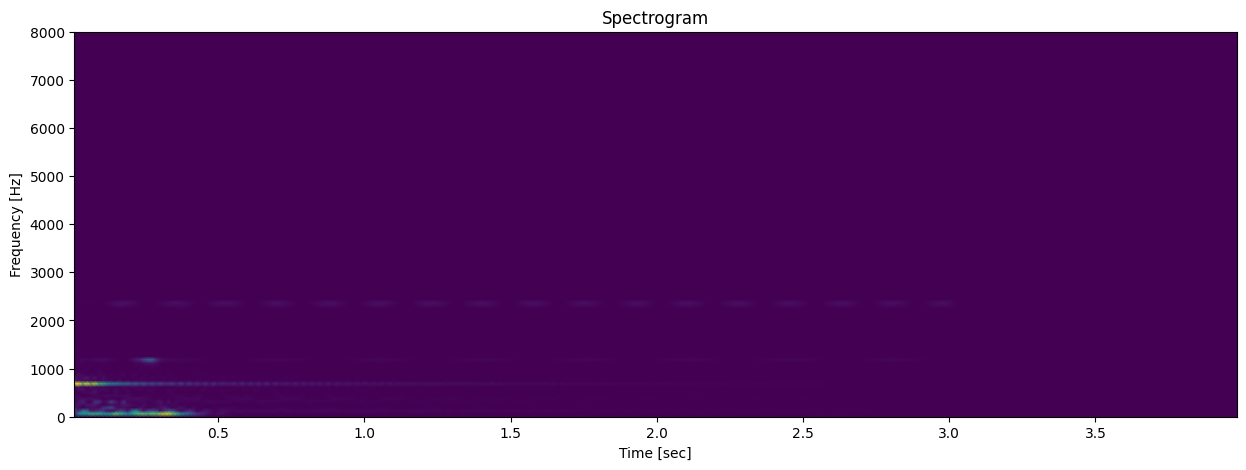

In [65]:
#Pick a random sample of each instrument
waveforms = add_waveform_to_list(pick_5_samples([bass, guitar, flutes, keyboards]))

#Combine the waveforms
combined_waveform = combine_waveforms(waveforms)

#Save the combined waveform to a wav file
waveform_to_wavfile(combined_waveform, "combo.wav", 16000)

#Plot the combined waveform
#plot_waveform(combined_waveform, 16000)

#Create spectogram

frequencies, times, spectrogram1 = spectrogram(combined_waveform)
plot_spectrogram([frequencies, times, spectrogram1])

In [82]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense
from keras.layers import Input

def build_model():
    model = Sequential()
    model.add(Input(shape=(129, 285, 1)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(4, activation='sigmoid'))  # Changed from 'softmax' to 'sigmoid'
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Changed from 'categorical_crossentropy' to 'binary_crossentropy'
    return model

model = build_model()

# Call the model on some dummy data to explicitly build it
dummy_data = np.zeros((1, 129, 285, 1))
model(dummy_data)

model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 127, 283, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 63, 141, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 61, 139, 128)   │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 30, 69, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 28, 67, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 14, 33, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 12, 31, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 6, 15, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1024)           │    11,797,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,134,084 (46.29 MB)

 Trainable params: 12,134,084 (46.29 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

#Generate data set and labels
data1, labels = gen_spectrogram_set(1000)

X_train, X_test, y_train, y_test = train_test_split(data1, np.array(labels), test_size=0.2, random_state=42)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
#hist = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))

(800, 129, 285, 1)
(800, 4)
(200, 129, 285, 1)
(200, 4)


In [94]:
# Train the model
history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_test, y_test))

25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 745ms/step - accuracy: 0.4818 - loss: 0.5186 - val_accuracy: 0.4600 - val_loss: 0.5314


In [90]:
y_preds = model.predict(X_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step


In [91]:
print(y_preds[:10])

[[0.6449387  0.5044297  0.9055386  0.631343  ]
 [0.4264087  0.4502457  0.88201636 0.34096295]
 [0.57229424 0.47881287 0.1500092  0.6240715 ]
 [0.7155082  0.47035053 0.5352051  0.5082462 ]
 [0.54537535 0.5879667  0.02912341 0.8352022 ]
 [0.39112553 0.52696395 0.98703015 0.29200584]
 [0.41269058 0.3778833  0.9824173  0.47495985]
 [0.64975774 0.5268553  0.00557467 0.7998104 ]
 [0.46310666 0.7712319  0.2423528  0.5702505 ]
 [0.56858945 0.49357632 0.11464716 0.6460215 ]]


In [92]:
y_test[:10]

array([[1., 0., 1., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 1.],
       [0., 1., 1., 0.],
       [1., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 1.]])